<a href="https://colab.research.google.com/github/MariannaMois/pet_project/blob/master/forecast_fact_payment_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Прогноз факта выплаты по страховке pet-project

**Проект с замечаниями ревьюера.**
Поработаем с [данными](https://github.com/obulygin/content/blob/main/possum_data/possum.csv) по клиентам автостроховой компании.




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/obulygin/content/main/car_insurance_data/car_insurance_data.csv")
df

,id,age,gender,race,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,DUIs,past_accidents,outcome
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,True,after 2015,False,True,10238,12000.0,sedan,0,0,0,False
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,False,before 2015,False,False,10238,16000.0,sedan,0,0,0,True
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,True,before 2015,False,False,10238,11000.0,sedan,0,0,0,False
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,True,before 2015,False,True,32765,11000.0,sedan,0,0,0,False
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,True,before 2015,False,False,32765,12000.0,sedan,2,0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,323164,26-39,female,majority,10-19y,university,upper class,0.582787,True,before 2015,False,False,10238,16000.0,sedan,0,0,1,False
9996,910346,26-39,female,majority,10-19y,none,middle class,0.522231,True,after 2015,False,True,32765,NaN,sedan,1,0,0,False
9997,468409,26-39,male,majority,0-9y,high school,middle class,0.470940,True,before 2015,False,True,10238,14000.0,sedan,0,0,0,False
9998,903459,26-39,female,majority,10-19y,high school,poverty,0.364185,False,before 2015,False,True,10238,13000.0,sedan,2,0,1,True


# Описание исследования

Целевая переменная 'outcome' - 1, если клиенту была выплачена страховка, иначе - 0.

Данные содержат следующий набор признаков про каждого клиента:

* 'id' - уникальный номер (id) клиента  
* 'age' - возрастная категория  
* 'gender' - пол  
* 'race' - раса  
* 'driving_experience' - опыт вождения  
* 'education' - образование    
* 'income' - уровень дохода  
* 'credit_score' - кредитный рейтинг  
* 'vehicle_ownership' - факт владения транспортным средством  
* 'vehicle_year' - год выпуска транспортного средства  
* 'married' - семейное положение  
* 'children' - наличие детей  
* 'postal_code' - почтовый индекс  
* 'annual_mileage' - годовой пробег  
* 'vehicle_type' - тип транспортного средства  
* 'speeding_violations' - количество случаев превышения скорости  
* 'DUIs' - количество случаев вождения в нетрезвом виде  
* 'past_accidents' - количество прошлых аварий

1) Прочитать данные.  
2) Проверьте, есть ли в них проблемы, которые помешают дальнейшей работе (пропуски, аномалии, некорректные типы данных).  
3) Проведите базовый EDA.  
4) Постройте модель, которая наиболее хорошо будет прогнозировать факт выплаты по страховке (`outcome`) по выбранным признакам. Самостоятельно выберите и обоснуйте выбор метрики качества.  
5) Напишите выводы о том, какие признаки наиболее значимы для прогноза.

Вы можете использовать любые инструменты подготовки данных, модели и способы их оптимизации, которые вам известны. Единственный критерий - максимизация метрики качества корректными способами.

Во всех действиях, содердащих случайную составляющую, фиксируйте `random_state=42`.

# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  object 
 2   gender               10000 non-null  object 
 3   race                 10000 non-null  object 
 4   driving_experience   10000 non-null  object 
 5   education            10000 non-null  object 
 6   income               10000 non-null  object 
 7   credit_score         9018 non-null   float64
 8   vehicle_ownership    10000 non-null  bool   
 9   vehicle_year         10000 non-null  object 
 10  married              10000 non-null  bool   
 11  children             10000 non-null  bool   
 12  postal_code          10000 non-null  int64  
 13  annual_mileage       9043 non-null   float64
 14  vehicle_type         10000 non-null  object 
 15  speeding_violations  10000 non-null  

In [ ]:
df.isnull().sum()

,0
id,0
age,0
gender,0
race,0
driving_experience,0
education,0
income,0
credit_score,982
vehicle_ownership,0
vehicle_year,0


In [ ]:
missing_percentage_mileage = df['annual_mileage'].isnull().mean() * 100
missing_percentage_credit_score = df['credit_score'].isnull().mean() * 100

print(f"Процент пропусков в annual_mileage: {missing_percentage_mileage:.2f}%")
print(f"Процент пропусков в credit_score: {missing_percentage_credit_score:.2f}%")

Процент пропусков в annual_mileage: 9.57%
Процент пропусков в credit_score: 9.82%


Для показателя credit_score в отношении пропусков можно выбрать заполнение нулевыми значениеми, предположив, что кредитный рейтинг отсутствует. Пропуски данных о пробеге лучше удалить.



In [ ]:
df['annual_mileage'] = df['annual_mileage'].fillna(0)

In [ ]:
df = df.dropna(subset=['credit_score'])

In [ ]:
df.isnull().sum()

,0
id,0
age,0
gender,0
race,0
driving_experience,0
education,0
income,0
credit_score,0
vehicle_ownership,0
vehicle_year,0


In [ ]:
print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 0


In [ ]:
df.describe()

,id,credit_score,postal_code,annual_mileage,speeding_violations,DUIs,past_accidents
count,9018.000000,9018.000000,9018.000000,9018.000000,9018.000000,9018.000000,9018.000000
mean,501452.392105,0.515813,19796.911510,10566.644489,1.480927,0.238856,1.057108
std,290500.755537,0.137688,18803.101827,4371.036558,2.246662,0.555004,1.654524
min,101.000000,0.053358,10238.000000,0.000000,0.000000,0.000000,0.000000
25%,249058.250000,0.417191,10238.000000,9000.000000,0.000000,0.000000,0.000000
50%,503338.000000,0.525033,10238.000000,11000.000000,0.000000,0.000000,0.000000
75%,756898.500000,0.618312,32765.000000,13000.000000,2.000000,0.000000,2.000000
max,999976.000000,0.960819,92101.000000,22000.000000,22.000000,6.000000,15.000000


# Признаки и классы

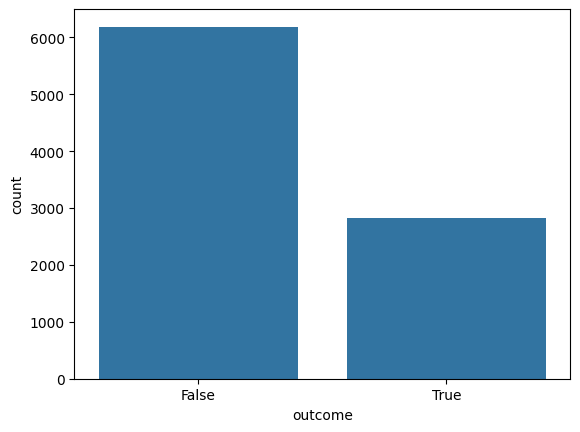

,proportion
outcome,
False,0.686294
True,0.313706


In [ ]:
sns.countplot(data=df, x='outcome')
plt.show()

# Распределение целевой переменной
df['outcome'].value_counts(normalize=True)

Классы несбалансированы: около 70% наблюдений принадлежат одному классу.

In [ ]:
cat_features = df.select_dtypes(include=['object', 'bool']).columns.tolist()
print("Категориальные признаки:", cat_features)

Категориальные признаки: ['age', 'gender', 'race', 'driving_experience', 'education', 'income', 'vehicle_ownership', 'vehicle_year', 'married', 'children', 'vehicle_type', 'outcome']


In [ ]:
# Порядковые признаки и их порядки
age_order = {'16-25':0, '26-39':1, '40-64':2, '65+':3}
driving_experience_order = {'0-9y':0, '10-19y':1, '20-29y':2, '30y+':3}
education_order = {'none':0, 'high school':1, 'university':2}
income_order = {'poverty':0, 'working class':1, 'middle class':2, 'upper class':3}
vehicle_year_order = {'before 2015':0, 'after 2015':1}

In [ ]:
df.loc[:, 'age'] = df['age'].map(age_order)
df.loc[:, 'driving_experience'] = df['driving_experience'].map(driving_experience_order)
df.loc[:, 'education'] = df['education'].map(education_order)
df.loc[:, 'income'] = df['income'].map(income_order)
df.loc[:, 'vehicle_year'] = df['vehicle_year'].map(vehicle_year_order)

In [ ]:
# Остальные категориальные признаки
remaining_cat_features = ['gender', 'race', 'vehicle_type', 'postal_code']

# Используем get_dummies
df = pd.get_dummies(df, columns=remaining_cat_features, drop_first=True)

In [ ]:
# Разделение данных на обучающую и тестовую выборки
X = df.drop(['id', 'outcome'], axis=1)
y = df['outcome'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Применение SMOTE к обучающим данным
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Проверим новое распределение классов
print("Распределение классов после SMOTE:")
print(y_train_sm.value_counts())

Распределение классов после SMOTE:
outcome
0    4951
1    4951
Name: count, dtype: int64


# Линейная регрессия

In [ ]:
# Разделение данных на признаки и целевую переменную
X = df.drop(['id', 'outcome'], axis=1)
y = df['outcome'].astype(int)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

Создание пайплайна для масштабирования и обучения

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        solver='saga',
        max_iter=5000,
        class_weight='balanced',
        random_state=42))
])

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Оценка на кросс-валидации

In [ ]:
scores_lr = cross_val_score(
    pipeline,
    X_train_sm,
    y_train_sm,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

print(f"ROC-AUC Логистической регрессии (кросс-валидация): {scores_lr.mean():.4f} ± {scores_lr.std():.4f}")

ROC-AUC Логистической регрессии (кросс-валидация): 0.9276 ± 0.0074


#Оценка на тестовой выборке

In [ ]:
pipeline.fit(X_train_sm, y_train_sm)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    random_state=42, solver='saga'))])

In [ ]:
y_pred_prob_lr = pipeline.predict_proba(X_test)[:,1]
y_pred_lr = pipeline.predict(X_test)


In [ ]:
# Оценка модели на тестовой выборке
roc_auc_lr = roc_auc_score(y_test, y_pred_prob_lr)
print(f"ROC-AUC Логистической регрессии на тестовой выборке: {roc_auc_lr:.4f}")

ROC-AUC Логистической регрессии на тестовой выборке: 0.9265


In [ ]:
print("\nОтчет о классификации на тестовой выборке:")
print(classification_report(y_test, y_pred_lr))


Отчет о классификации на тестовой выборке:
              precision    recall  f1-score   support

           0       0.93      0.85      0.88      1238
           1       0.72      0.86      0.78       566

    accuracy                           0.85      1804
   macro avg       0.82      0.85      0.83      1804
weighted avg       0.86      0.85      0.85      1804



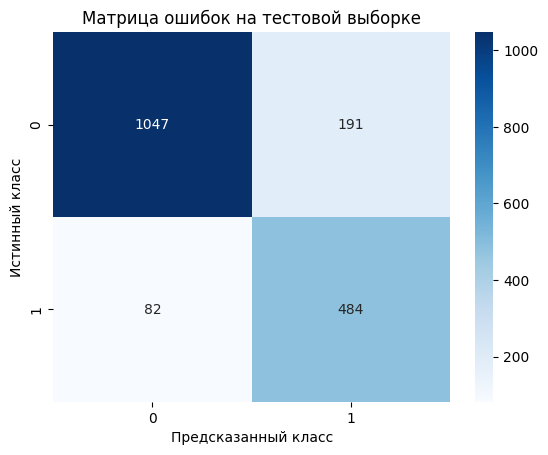

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок на тестовой выборке')
plt.show()

# Случайный лес

In [ ]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_pred_prob_rf = rf.predict_proba(X_test)[:,1]
y_pred_rf = rf.predict(X_test)

In [ ]:
scores_rf = cross_val_score(
    estimator=rf,
    X=X_train,
    y=y_train,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"ROC-AUC Случайный лес (кросс-валидация): {scores_rf.mean():.4f} ± {scores_rf.std():.4f}")

ROC-AUC Случайный лес (кросс-валидация): 0.9012 ± 0.0066


Наиболее значимые признаки:

credit_score: кредитный рейтинг клиента.
age: возрастная категория.
driving_experience: опыт вождения.
past_accidents: количество прошлых аварий.
speeding_violations: количество случаев превышения скорости.
DUIs: количество случаев вождения в нетрезвом виде.
income: уровень дохода.
annual_mileage: годовой пробег.

Метрика качества: был выбран показатель ROC-AUC, так как он наиболее устойчив к несбалансированным классам и отражает способность модели различать классы.

Вывод: Линейная регрессия показала наилучший результат по метрике ROC-AUC. Наиболее значимыми признаками оказались те, которые напрямую связаны с рисковым поведением водителя и его финансовым положением.